In [1]:
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, RNN, InputLayer, SimpleRNN
from pickle import load
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pickle import dump
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2022-06-03 08:16:59.077026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 08:16:59.077271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 08:16:59.081150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 08:16:59.081385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 08:16:59.081896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [3]:
host = ''
user = ''
passw = ''
client = MongoClient(host = host, username=user, password=passw)
db = client.Ebalance
col = db["emv210"]
data1 = col.find({},{"datetime" : 1, "kwh_p_tot_r" : 1}).sort("_id", -1)
list_cur = list(data1)
df = pd.DataFrame(list_cur)

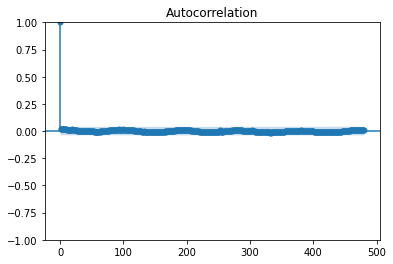

In [4]:
df_t = df[["datetime", "kwh_p_tot_r",]]
df_t.set_index(["datetime"])
df_t.head()
fig = tsaplots.plot_acf(df_t["kwh_p_tot_r"], lags=480) 
plt.show()

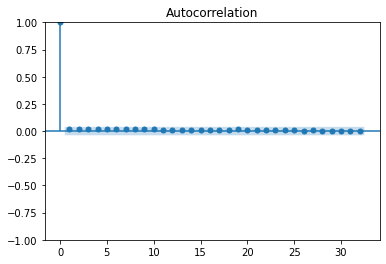

In [62]:
fig = tsaplots.plot_acf(df_t["kwh_p_tot_r"], lags=32) 
plt.show()

In [5]:
db = client.Ebalance
col = db["openweather"]
column_names = ["datetime","weather", "temp_min", "temp_max", "pressure", "humidity", "wind"]


df2 = pd.DataFrame(columns = column_names)

data = col.find()
df2 = pd.DataFrame(data,columns = column_names)
df2.head()

,datetime,weather,temp_min,temp_max,pressure,humidity,wind
0,2022/01/27 12:00:00,Clouds,13.24,16.09,1024,58,4.92
1,2022/01/27 12:15:00,Clouds,13.24,16.65,1024,59,3.58
2,2022/01/27 12:30:00,Clouds,14.73,16.65,1024,66,4.92
3,2022/01/27 12:45:00,Clouds,15.29,17.21,1024,65,2.24
4,2022/01/27 13:15:00,Clouds,15.70,17.47,1023,65,3.13


In [6]:
df_final = pd.merge(left=df, right=df2, left_on=["datetime"], right_on=[ "datetime"])
df_final.head()

,_id,datetime,kwh_p_tot_r,weather,temp_min,temp_max,pressure,humidity,wind
0,6299c3067784b6cbf365894a,2022/06/03 10:15:00,41.2,Clouds,21.57,24.14,1013,58,7.72
1,6299bf829207a95c74d85010,2022/06/03 10:00:00,39.7,Clouds,21.02,24.43,1013,59,7.72
2,6299bbfe74e461d6a73c4ab9,2022/06/03 09:45:00,39.3,Clouds,21.02,24.43,1013,59,7.72
3,6299b87a4c1dd69e801c78bb,2022/06/03 09:30:00,40.0,Clouds,19.58,23.87,1013,61,8.23
4,6299b4f64c1dd69e801c78b6,2022/06/03 09:15:00,39.6,Clouds,20.14,23.32,1013,60,8.23


In [7]:
df_final['datetime'] = pd.to_datetime(df_final.datetime)
df_final['dayofweek'] = df_final['datetime'].dt.dayofweek
df_final['datetime'] = df_final['datetime'].dt.strftime('%d/%m/%Y %H:%M:%S')
df_final["day"] = df_final["datetime"].str[0:2]
df_final["month"] = df_final["datetime"].str[3:5]
df_final["year"] = df_final["datetime"].str[6:10]
df_final["hour"] = df_final["datetime"].str[11:13]
df_final["minute"] = df_final["datetime"].str[14:16]
df_final["second"] = df_final["datetime"].str[17:19]
df_final= df_final.drop(['datetime', "_id"], axis = 1)
df_final["weather"] = df_final["weather"].replace("Clouds", 0)
df_final["weather"] = df_final["weather"].replace("Clear", 1)
df_final["weather"] = df_final["weather"].replace("Rain", 2)
df_final["weather"] = df_final["weather"].replace("Drizzle", 3)
df_final["weather"] = df_final["weather"].replace("Mist", 4)
df_final["weather"] = df_final["weather"].replace("Thunderstorm", 5)
df_final["weather"] = df_final["weather"].replace("Haze", 6)
df_final["weather"] = df_final["weather"].replace("Fog", 7)
df_final.astype('float32').dtypes

kwh_p_tot_r    float32
weather        float32
temp_min       float32
temp_max       float32
pressure       float32
humidity       float32
wind           float32
dayofweek      float32
day            float32
month          float32
year           float32
hour           float32
minute         float32
second         float32
dtype: object

In [8]:
df_final.tail()

,kwh_p_tot_r,weather,temp_min,temp_max,pressure,humidity,wind,dayofweek,day,month,year,hour,minute,second
2278,32.0,0,19.09,23.24,1021,68,3.60,3,05,05,2022,15,15,00
2279,33.3,0,19.09,22.69,1021,67,3.60,3,05,05,2022,15,00,00
2280,33.4,0,19.09,23.24,1021,68,3.60,3,05,05,2022,14,45,00
2281,34.9,0,19.09,22.69,1021,68,4.12,3,05,05,2022,14,30,00
2282,34.5,0,19.09,21.57,1020,71,3.60,3,05,05,2022,14,15,00


In [9]:
df_final.corr(method ='pearson')["kwh_p_tot_r"]

kwh_p_tot_r    1.000000
weather       -0.198179
temp_min       0.331709
temp_max       0.353334
pressure       0.010230
humidity      -0.326946
wind           0.241829
dayofweek     -0.389322
Name: kwh_p_tot_r, dtype: float64

In [10]:
df_final.corr(method ='kendall')["kwh_p_tot_r"]

kwh_p_tot_r    1.000000
weather       -0.143354
temp_min       0.153493
temp_max       0.164972
pressure       0.123549
humidity      -0.174208
wind           0.182214
dayofweek     -0.307173
Name: kwh_p_tot_r, dtype: float64

In [11]:
df_final.corr(method ='spearman')["kwh_p_tot_r"]

kwh_p_tot_r    1.000000
weather       -0.175083
temp_min       0.241710
temp_max       0.261495
pressure       0.160227
humidity      -0.264011
wind           0.259793
dayofweek     -0.417729
Name: kwh_p_tot_r, dtype: float64

In [12]:
len(df_final.index)
df_final["prev_kwh_1"]= 0
df_final["prev_kwh_2"]= 0
df_final["prev_kwh_3"]= 0
df_final["prev_kwh_4"]= 0
df_final["prev_kwh_5"]= 0
df_final["prev_kwh_6"]= 0
df_final["prev_kwh_7"]= 0
df_final["prev_kwh_8"]= 0
df_final["pred_kwh_1"]= 0
df_final["pred_kwh_2"]= 0
df_final["pred_kwh_3"]= 0
df_final["pred_kwh_4"]= 0


for index in df_final.index:
    if index >= 32 and index < len(df_final.index)-4:
        
        df_final["prev_kwh_1"][index]= df_final["kwh_p_tot_r"][index-4]
        df_final["prev_kwh_2"][index]= df_final["kwh_p_tot_r"][index-8]
        df_final["prev_kwh_3"][index]= df_final["kwh_p_tot_r"][index-12]
        df_final["prev_kwh_4"][index]= df_final["kwh_p_tot_r"][index-16]
        df_final["prev_kwh_5"][index]= df_final["kwh_p_tot_r"][index-20]
        df_final["prev_kwh_6"][index]= df_final["kwh_p_tot_r"][index-24]
        df_final["prev_kwh_7"][index]= df_final["kwh_p_tot_r"][index-28]
        df_final["prev_kwh_8"][index]= df_final["kwh_p_tot_r"][index-32]
        
        df_final["pred_kwh_1"][index]= df_final["kwh_p_tot_r"][index+1]
        df_final["pred_kwh_2"][index]= df_final["kwh_p_tot_r"][index+2]
        df_final["pred_kwh_3"][index]= df_final["kwh_p_tot_r"][index+3]
        df_final["pred_kwh_4"][index]= df_final["kwh_p_tot_r"][index+4]


        
        #print(index)
df_final.drop(df_final.tail(4).index,inplace = True)
df_final.drop(df_final.head(32).index,inplace = True)
df_final.tail(32)

/tmp/ipykernel_4004495/635138436.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["prev_kwh_1"][index]= df_final["kwh_p_tot_r"][index-4]
/tmp/ipykernel_4004495/635138436.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["prev_kwh_2"][index]= df_final["kwh_p_tot_r"][index-8]
/tmp/ipykernel_4004495/635138436.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["prev_kwh_3"][index]= df_final["kwh_p_tot_r"

,kwh_p_tot_r,weather,temp_min,temp_max,pressure,humidity,wind,dayofweek,day,month,...,prev_kwh_3,prev_kwh_4,prev_kwh_5,prev_kwh_6,prev_kwh_7,prev_kwh_8,pred_kwh_1,pred_kwh_2,pred_kwh_3,pred_kwh_4
2247,24.9,1,16.02,18.89,1022,67,0.89,3,05,05,...,26,25,30,26,29,29,29,25,23,29
2248,29.3,1,16.02,18.89,1022,66,1.79,3,05,05,...,30,26,25,30,24,29,25,23,29,24
2249,25.1,1,16.57,17.76,1023,77,1.03,3,05,05,...,25,31,26,26,29,25,23,29,24,24
2250,23.9,1,17.09,18.03,1022,77,1.54,3,05,05,...,25,26,30,25,25,23,29,24,24,34
2251,29.4,1,17.09,20.00,1021,67,1.54,3,05,05,...,28,26,25,30,26,29,24,24,34,28
2252,24.6,1,16.95,20.00,1021,65,1.54,3,05,05,...,24,30,26,25,30,24,24,34,28,24
2253,24.3,1,17.51,20.56,1021,65,2.06,3,05,05,...,24,25,31,26,26,29,34,28,24,26
2254,34.0,1,18.06,20.56,1021,67,2.57,3,05,05,...,29,25,26,30,25,25,28,24,26,24
2255,28.7,1,18.06,20.56,1021,67,2.57,3,05,05,...,23,28,26,25,30,26,24,26,24,25
2256,24.8,1,18.06,21.12,1021,66,2.57,3,05,05,...,24,24,30,26,25,30,26,24,25,28


<AxesSubplot:>

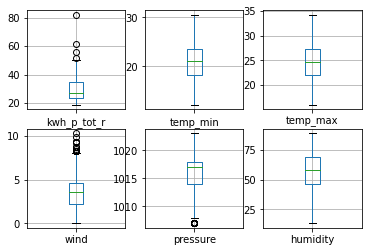

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3)

df_final.boxplot(column=['kwh_p_tot_r'], ax=axes[0,0])
df_final.boxplot(column=['temp_min'], ax=axes[0,1])
df_final.boxplot(column=['temp_max'], ax=axes[0,2])
df_final.boxplot(column=['wind'], ax=axes[1,0])
df_final.boxplot(column=['pressure'], ax=axes[1,1])
df_final.boxplot(column=['humidity'], ax=axes[1,2])

<AxesSubplot:xlabel='kwh_p_tot_r', ylabel='dayofweek'>

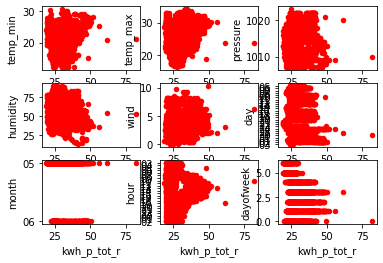

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3)


df_final.plot(kind='scatter', x='kwh_p_tot_r', y='temp_min', color='r',ax=axes[0,0])  
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='temp_max', color='r',ax=axes[0,1])  
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='pressure', color='r',ax=axes[0,2])  
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='humidity', color='r',ax=axes[1,0])  
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='wind', color='r',ax=axes[1,1])
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='day', color='r',ax=axes[1,2])  
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='month', color='r',ax=axes[2,0])  
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='hour', color='r',ax=axes[2,1])  
df_final.plot(kind='scatter', x='kwh_p_tot_r', y='dayofweek', color='r',ax=axes[2,2])  

In [16]:
labels=np.array([df_final['pred_kwh_1'], df_final['pred_kwh_2'], df_final['pred_kwh_3'], df_final['pred_kwh_4']])
features = df_final.iloc[:,:-4]
X=features
y=np.ravel(labels)

In [17]:
X[:10]

,kwh_p_tot_r,weather,temp_min,temp_max,pressure,humidity,wind,dayofweek,day,month,...,minute,second,prev_kwh_1,prev_kwh_2,prev_kwh_3,prev_kwh_4,prev_kwh_5,prev_kwh_6,prev_kwh_7,prev_kwh_8
32,24.0,1,21.92,23.34,1012,55,4.63,4,03,06,...,00,00,23,24,24,23,25,28,39,41
33,25.8,1,21.92,23.34,1012,54,4.63,4,03,06,...,45,00,23,28,24,24,25,36,38,39
34,23.8,1,21.02,23.89,1012,54,4.12,4,03,06,...,30,00,25,28,24,24,24,35,36,39
35,24.5,1,21.57,24.09,1012,52,4.12,4,03,06,...,15,00,23,26,22,23,25,26,32,40
36,26.2,1,21.57,24.45,1012,52,4.12,4,03,06,...,00,00,24,23,24,24,23,25,28,39
37,24.4,1,21.57,24.45,1012,51,3.60,4,03,06,...,45,00,25,23,28,24,24,25,36,38
38,24.8,1,22.13,24.45,1012,51,3.60,4,03,06,...,30,00,23,25,28,24,24,24,35,36
39,26.2,1,22.36,25.09,1012,48,4.12,4,03,06,...,15,00,24,23,26,22,23,25,26,32
40,25.5,1,22.21,25.09,1012,47,4.12,4,03,06,...,00,00,26,24,23,24,24,23,25,28
41,23.4,1,22.21,25.56,1012,46,4.92,3,02,06,...,45,00,24,25,23,28,24,24,25,36


In [18]:
y = labels.reshape((len(features), 4))
y

array([[25, 23, 24, 26],
       [24, 24, 26, 25],
       [23, 26, 25, 25],
       ...,
       [31, 32, 32, 31],
       [32, 32, 33, 32],
       [33, 33, 34, 34]])

In [19]:
X_train, X_aux, y_train, Y_aux = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_aux, Y_aux, test_size=0.5, random_state=42, shuffle=True)

In [20]:
len(X_train[0:10].columns)

22

In [21]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
dump(scaler, open('scaler_final.pkl', 'wb'))

In [22]:
def build_model_dense():
    model = Sequential([
    Dense(64, activation='relu', input_shape=[len(features.columns)]),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [23]:
def build_model_dense_2():
    model = Sequential([
    Dense(512, activation='relu', input_shape=[len(features.columns)]),
    Dense(512, activation='relu'),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [24]:
def build_model_dense_3():
    model = Sequential([
    Dense(1024, activation='relu', input_shape=[len(features.columns)]),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [25]:
def build_model_simplernn():
    model = Sequential([
    SimpleRNN(64, input_shape=(None, 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [52]:
def build_model_lstm():
    model = Sequential([
    LSTM(64, input_shape=(None, 1)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [27]:
def plot_history(history, ylim=10000, ylim2=10000):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,ylim])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,ylim2])
    plt.legend()
    plt.show()

In [29]:
EPOCHS = 8000
BATCH = 1

In [30]:
model_dense = build_model_dense()
model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1472      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,732
Trainable params: 1,732
Non-trainable params: 0
_________________________________________________________________


2022-06-03 08:17:59.519188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 08:17:59.643193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 08:17:59.643414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 08:17:59.643882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [31]:
history_dense = model_dense.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

2022-06-03 08:18:01.437460: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


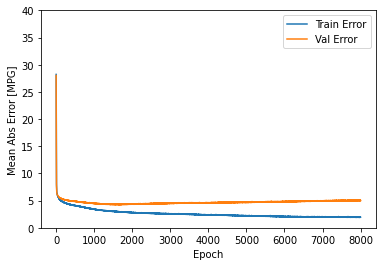

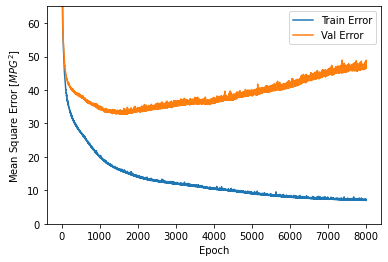

In [46]:
plot_history(history_dense, 40, 65)

In [33]:
model_dense_2 = build_model_dense_2()
model_dense_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               11776     
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 276,484
Trainable params: 276,484
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_dense_2 = model_dense_2.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

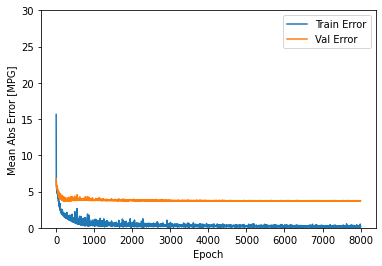

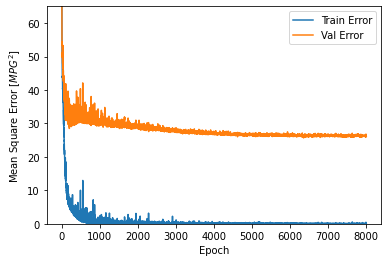

In [47]:
plot_history(history_dense_2, 30, 65)

In [36]:
model_dense_3 = build_model_dense_3()
model_dense_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              23552     
                                                                 
 dense_6 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 27,652
Trainable params: 27,652
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_dense_3 = model_dense_3.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

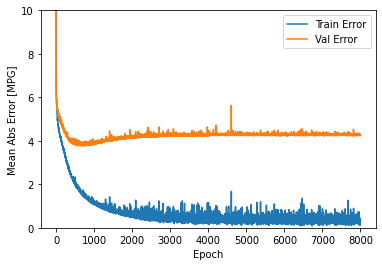

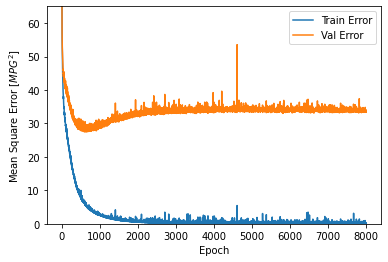

In [48]:
plot_history(history_dense_3, 10, 65)

In [39]:
EPOCHS = 3000
BATCH = 1
X_train, X_aux, y_train, Y_aux = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_aux, Y_aux, test_size=0.5, random_state=42, shuffle=False)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [40]:
model_simple_rnn = build_model_simplernn()
model_simple_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 4)                 132       
                                                                 
Total params: 10,596
Trainable params: 10,596
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

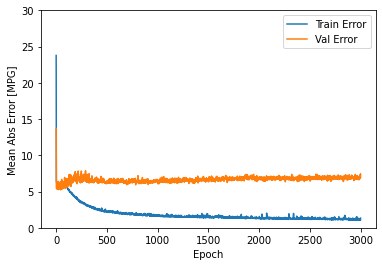

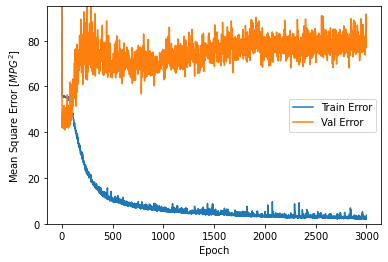

In [50]:
plot_history(history_simple_rnn, 30, 95)

In [43]:
model_lstm = build_model_lstm()
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 4)                 132       
                                                                 
Total params: 23,268
Trainable params: 23,268
Non-trainable params: 0
_________________________________________________________________


In [54]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=0)

2022-06-03 09:09:14.001522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


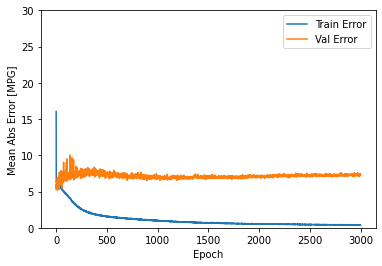

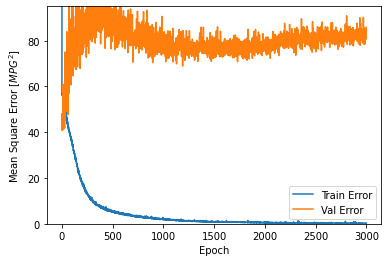

In [55]:
plot_history(history_lstm, 30, 95)

In [56]:
model_dense.evaluate(X_test, y_test) 

15/15 [==============================] - 0s 888us/step - loss: 26.3919 - mae: 3.5752 - mse: 26.3919


[26.39190101623535, 3.575230598449707, 26.39190101623535]

In [57]:
model_dense_2.evaluate(X_test, y_test) 

15/15 [==============================] - 0s 840us/step - loss: 14.7446 - mae: 1.8079 - mse: 14.7446


[14.744619369506836, 1.8078771829605103, 14.744619369506836]

In [58]:
model_dense_3.evaluate(X_test, y_test) 

15/15 [==============================] - 0s 787us/step - loss: 15.7173 - mae: 2.0225 - mse: 15.7173


[15.717268943786621, 2.0224530696868896, 15.717268943786621]

In [59]:
model_simple_rnn.evaluate(X_test, y_test) 

15/15 [==============================] - 0s 2ms/step - loss: 77.7790 - mae: 6.8036 - mse: 77.7790


[77.77902221679688, 6.80364465713501, 77.77902221679688]

In [60]:
model_lstm.evaluate(X_test, y_test) 

15/15 [==============================] - 0s 1ms/step - loss: 86.2782 - mae: 7.2004 - mse: 86.2782


[86.27821350097656, 7.200389385223389, 86.27821350097656]

In [61]:
model_dense.save('model_dense.h5')
model_dense_2.save('model_dense_2.h5')
model_dense_3.save('model_dense_3.h5')
model_simple_rnn.save('model_simple_rnn.h5')
model_lstm.save('model_lstm.h5')